In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [3]:
%%time
train_df = pd.read_csv("train_modified.csv")
test_df = pd.read_csv("test_modified.csv")

Wall time: 1.24 s


In [8]:
t

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,37,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,30,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,34,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,28,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,31,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [5]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [6]:
%%time
missing_data(train_df)

Wall time: 771 ms


,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,float64,float64,object,float64,float64,int64,int64,int64,int64,int64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


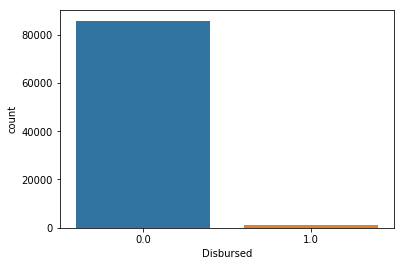

In [9]:
sns.countplot(train_df['Disbursed'])

In [11]:
print("There are {}% target values with 1".format(100 * train_df["Disbursed"].value_counts()[1]/train_df.shape[0]))

There are 1.462882096069869% target values with 1


In [14]:
target='Disbursed'
IDcol='ID'

In [18]:
%%time
features = [x for x in train_df.columns if x not in [target, IDcol]]
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

Wall time: 818 ms


In [20]:
correlations.tail()

,level_0,level_1,0
2367,Gender_1,Gender_0,1.0
2371,Mobile_Verified_1,Mobile_Verified_0,1.0
2372,Mobile_Verified_0,Mobile_Verified_1,1.0
2387,Var1_13,Interest_Rate_Missing,1.0
2388,Var1_13,EMI_Loan_Submitted_Missing,1.0


In [21]:
features = [c for c in train_df.columns if c not in [IDcol, target]]
target = train_df['Disbursed']

In [23]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [24]:
folds = StratifiedKFold(n_splits=3, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()



In [27]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits



Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.829272	valid_1's auc: 0.792145
[2000]	training's auc: 0.845625	valid_1's auc: 0.810277
[3000]	training's auc: 0.853031	valid_1's auc: 0.816899
[4000]	training's auc: 0.857667	valid_1's auc: 0.819155
[5000]	training's auc: 0.860749	valid_1's auc: 0.821574
[6000]	training's auc: 0.863384	valid_1's auc: 0.823222
[7000]	training's auc: 0.865677	valid_1's auc: 0.823894
[8000]	training's auc: 0.867539	valid_1's auc: 0.824707
[9000]	training's auc: 0.86923	valid_1's auc: 0.825757
[10000]	training's auc: 0.871181	valid_1's auc: 0.826737
Did not meet early stopping. Best iteration is:
[9998]	training's auc: 0.871185	valid_1's auc: 0.826738
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.816744	valid_1's auc: 0.803892
[2000]	training's auc: 0.838144	valid_1's auc: 0.820275
[3000]	training's auc: 0.848144	valid_1's auc: 0.826635
[4000]	training's auc: 0.8

In [28]:
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

CV score: 0.82149 


In [34]:
a=clf.predict(test_df[features])

In [35]:
a

array([0.00730101, 0.05504337, 0.00146201, ..., 0.00235334, 0.02362593,
       0.00679581])

(array([3.3018e+04, 3.5360e+03, 8.0800e+02, 2.2700e+02, 8.0000e+01,
        2.5000e+01, 1.4000e+01, 5.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([1.46219440e-04, 2.83113043e-02, 5.64763892e-02, 8.46414741e-02,
        1.12806559e-01, 1.40971644e-01, 1.69136729e-01, 1.97301814e-01,
        2.25466898e-01, 2.53631983e-01, 2.81797068e-01]),
 <a list of 10 Patch objects>)

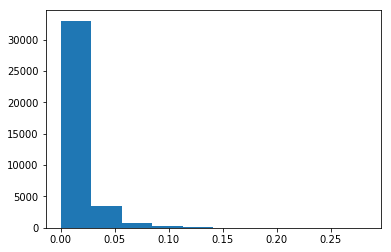

In [38]:
import matplotlib.pyplot as plt
plt.hist(clf.predict(test_df[features]))